#  Telecomunicaciones: identificar operadores ineficaces

## Introduccion 

### para el servicio de telefonía virtual CallMeMaybe. Este proyecto se centra en una nueva función que busca proporcionar a los supervisores información valiosa sobre la eficiencia de los operadores.

### El objetivo principal es identificar a los operadores menos eficaces, aquellos que tienen una gran cantidad de llamadas perdidas y tiempos de espera prolongados. Además, también queremos analizar la eficacia de los operadores encargados de realizar llamadas salientes.

##  Descripcion  
### Vamos a analizar el servicio de telefonía virtual CallMeMaybe, sus clientes son organizaciones que necesitan distribuir gran cantidad de llamadas entrantes y salientes con bastantes operadores, los operadores tambien tienen llamadas internas como apoyo, identificaremos los rendimientos de operadores y de llamadas para verificar que operador es eficas o no y como podemos hacer correciones para elevar rendimientos.

## Descripcione de los datos 
 
   `telecom_dataset_us.csv`
- `user_id`: ID de la cuenta de cliente
- `date`: fecha en la que se recuperaron las estadísticas
- `direction`: "dirección" de llamada (`out` para saliente, `in` para entrante)
- `internal`: si la llamada fue interna (entre los operadores de un cliente o clienta)
- `operator_id`: identificador del operador
- `is_missed_call`: si fue una llamada perdida
- `calls_count`: número de llamadas
- `call_duration`: duración de la llamada (sin incluir el tiempo de espera)
- `total_call_duration`: duración de la llamada (incluido el tiempo de espera)

 

`telecom_clients_us.csv` 

- `user_id`: ID de usuario/a
- `tariff_plan`: tarifa actual de la clientela
- `date_start`: fecha de registro de la clientela

In [4]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from scipy.stats import pearsonr
import numpy as np

In [5]:
df = pd.read_csv('telecom_dataset_us.csv')
df_clientes = pd.read_csv('telecom_clients_us.csv')   

In [6]:
def clean_data(data):
    print()
    print(data.info())
    print()
    print(data.head())
    print()
    print(data.describe())
    print('missing values')
    print(data.isna().sum())
    print()
    print('duplicates', data.duplicated().sum())
    print()

In [7]:
df['date'] = pd.to_datetime(df['date'])


In [8]:
clean_data(df)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype                    
---  ------               --------------  -----                    
 0   user_id              53902 non-null  int64                    
 1   date                 53902 non-null  datetime64[ns, UTC+03:00]
 2   direction            53902 non-null  object                   
 3   internal             53785 non-null  object                   
 4   operator_id          45730 non-null  float64                  
 5   is_missed_call       53902 non-null  bool                     
 6   calls_count          53902 non-null  int64                    
 7   call_duration        53902 non-null  int64                    
 8   total_call_duration  53902 non-null  int64                    
dtypes: bool(1), datetime64[ns, UTC+03:00](1), float64(1), int64(4), object(2)
memory usage: 3.3+ MB
None

   user_id                      date

In [9]:
df.drop_duplicates(inplace=True)


In [10]:
df['call_duration_minutes'] = df['call_duration'] / 60
df['total_call_duration_minutes'] = df['total_call_duration'] / 60

In [11]:
clean_data(df_clientes)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB
None

   user_id tariff_plan  date_start
0   166713           A  2019-08-15
1   166901           A  2019-08-23
2   168527           A  2019-10-29
3   167097           A  2019-09-01
4   168193           A  2019-10-16

             user_id
count     732.000000
mean   167431.927596
std       633.810383
min    166373.000000
25%    166900.750000
50%    167432.000000
75%    167973.000000
max    168606.000000
missing values
user_id        0
tariff_plan    0
date_start     0
dtype: int64

duplicates 0



In [12]:
mask = (df['direction'] == 'in') & (df['is_missed_call'] == True)
df_missed_in = df[mask]

operadores_ineficaces = df_missed_in.groupby('operator_id', as_index=False).agg(
    total_llamadas_perdidas=('calls_count', 'sum'),
    total_duracion_perdida=('call_duration', 'sum') 
)

In [13]:
total_in = df[df['direction'] == 'in'].groupby('operator_id')['calls_count'].sum().reset_index(name='total_llamadas_in')

operadores_ineficaces = pd.merge(operadores_ineficaces, total_in, on='operator_id', how='left')

operadores_ineficaces['tasa_perdidas'] = operadores_ineficaces['total_llamadas_perdidas'] / operadores_ineficaces['total_llamadas_in']
operadores_ineficaces['tasa_perdidas'] = operadores_ineficaces['tasa_perdidas'].round(2)

In [14]:
operadores_ineficaces = operadores_ineficaces.sort_values(by='total_llamadas_perdidas', ascending=False)

umbral = operadores_ineficaces['total_llamadas_perdidas'].quantile(0.95)
operadores_problematicos = operadores_ineficaces[operadores_ineficaces['total_llamadas_perdidas'] >= umbral]

El percentil 95% representa el valor por debajo del cual se encuentra el 95% de los datos. Los operadores que están por encima de este umbral pertenecen al 5% superior en llamadas perdidas, lo que los hace candidatos a ser considerados "extremos".

In [15]:
operadores_problematicos

,operator_id,total_llamadas_perdidas,total_duracion_perdida,total_llamadas_in,tasa_perdidas
98,913942.0,52,25,2467,0.02
196,940588.0,30,4358,2127,0.01
210,944226.0,30,66,180,0.17
6,885890.0,26,5,1244,0.02
206,944216.0,24,194,235,0.10
179,937956.0,24,69,773,0.03
222,951508.0,21,1456,336,0.06
5,885876.0,20,5,992,0.02
208,944220.0,18,1,265,0.07
209,944222.0,17,30,185,0.09


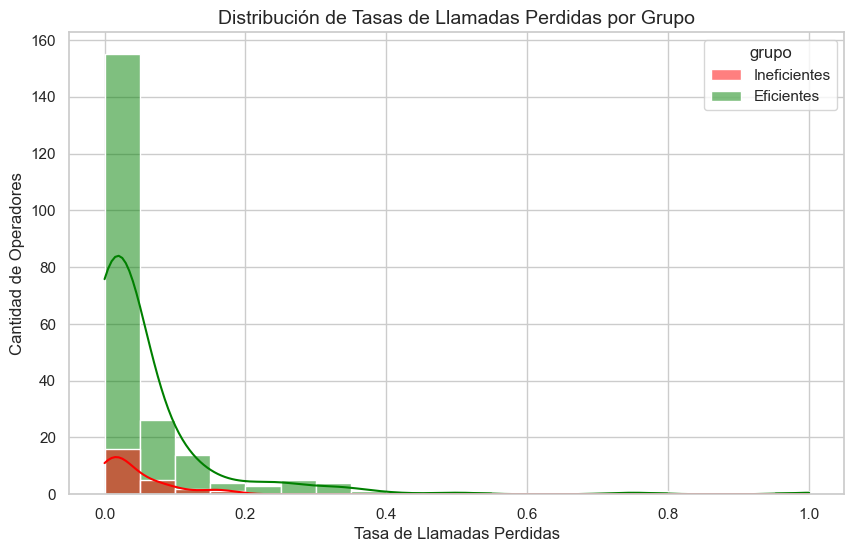

In [16]:
umbral = operadores_ineficaces['total_llamadas_perdidas'].quantile(0.90)
operadores_ineficaces['grupo'] = np.where(
    operadores_ineficaces['total_llamadas_perdidas'] >= umbral, 
    'Ineficientes', 
    'Eficientes'
)

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

sns.histplot(
    data=operadores_ineficaces,
    x='tasa_perdidas',
    hue='grupo',
    bins=20,
    kde=True,
    palette={'Ineficientes': 'red', 'Eficientes': 'green'}
)

plt.title('Distribución de Tasas de Llamadas Perdidas por Grupo', fontsize=14)
plt.xlabel('Tasa de Llamadas Perdidas', fontsize=12)
plt.ylabel('Cantidad de Operadores', fontsize=12)

plt.show()


en este histograma podemos visualizar la cantidad de de operadores con tasas de llamadas perdidas los cuales los verdes nos marcan operadores eficiente y los rojo operadores que estarian muy por debajo de las metricas  aproximadamente entre 18

C:\Users\Criz1\AppData\Local\Temp\ipykernel_18456\2123554564.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


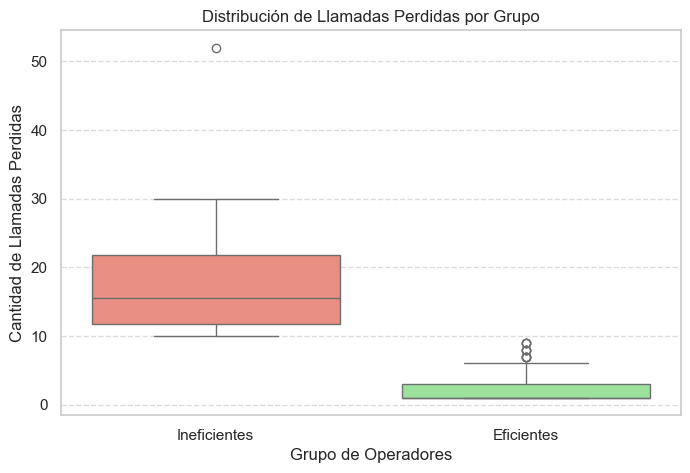

In [17]:
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=operadores_ineficaces,
    x='grupo',
    y='total_llamadas_perdidas',
    palette={'Ineficientes': 'salmon', 'Eficientes': 'lightgreen'}
)

plt.title('Distribución de Llamadas Perdidas por Grupo')
plt.xlabel('Grupo de Operadores')
plt.ylabel('Cantidad de Llamadas Perdidas')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

En la siguiente boxplot visualizamos  la distribucion de llamadas perdidas entre usuarios eficientes y no eficientes viendo alrededor de cuantas son las llamadas que perdieron los usuarios 

In [18]:
df_in = df[df["direction"] == "in"].copy()
df_in["wait_time"] = df_in["total_call_duration"] - df_in["call_duration"]


In [19]:
operadores_metrics = df_in.groupby("operator_id").agg(
    total_llamadas_in=("calls_count", "sum"),
    total_perdidas=("is_missed_call", "sum"),
    avg_wait_time=("wait_time", "mean")
).reset_index()

operadores_metrics["tasa_perdidas"] = operadores_metrics["total_perdidas"] / operadores_metrics["total_llamadas_in"]


In [20]:
df_in

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,call_duration_minutes,total_call_duration_minutes,wait_time
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4,0.000000,0.066667,4
7,166377,2019-08-05 00:00:00+03:00,in,False,NaN,True,6,0,35,0.000000,0.583333,35
9,166377,2019-08-06 00:00:00+03:00,in,False,NaN,True,4,0,62,0.000000,1.033333,62
17,166377,2019-08-07 00:00:00+03:00,in,False,NaN,True,2,0,24,0.000000,0.400000,24
26,166377,2019-08-12 00:00:00+03:00,in,False,880028.0,False,1,407,411,6.783333,6.850000,4
...,...,...,...,...,...,...,...,...,...,...,...,...
53889,168603,2019-11-28 00:00:00+03:00,in,False,NaN,True,1,0,30,0.000000,0.500000,30
53891,168606,2019-11-08 00:00:00+03:00,in,False,957922.0,True,1,0,7,0.000000,0.116667,7
53893,168606,2019-11-08 00:00:00+03:00,in,False,NaN,True,6,0,121,0.000000,2.016667,121
53894,168606,2019-11-08 00:00:00+03:00,in,False,957922.0,False,2,686,705,11.433333,11.750000,19


In [21]:
operadores_ineficaces.sort_values(by= 'grupo', ascending= False)

,operator_id,total_llamadas_perdidas,total_duracion_perdida,total_llamadas_in,tasa_perdidas,grupo
98,913942.0,52,25,2467,0.02,Ineficientes
207,944218.0,15,60,245,0.06,Ineficientes
196,940588.0,30,4358,2127,0.01,Ineficientes
138,925922.0,10,4,418,0.02,Ineficientes
22,893804.0,10,3,2433,0.00,Ineficientes
...,...,...,...,...,...,...
18,891410.0,2,1,660,0.00,Eficientes
10,888534.0,2,133,61,0.03,Eficientes
9,888532.0,2,0,12,0.17,Eficientes
121,920852.0,2,0,192,0.01,Eficientes


In [22]:
umbral_tasa = operadores_metrics["tasa_perdidas"].quantile(0.90)
umbral_wait = operadores_metrics["avg_wait_time"].quantile(0.90)

operadores_ineficaces = operadores_metrics[
    (operadores_metrics["tasa_perdidas"] >= umbral_tasa) &
    (operadores_metrics["avg_wait_time"] >= umbral_wait) &
    (operadores_metrics["total_llamadas_in"] > 50)  
]


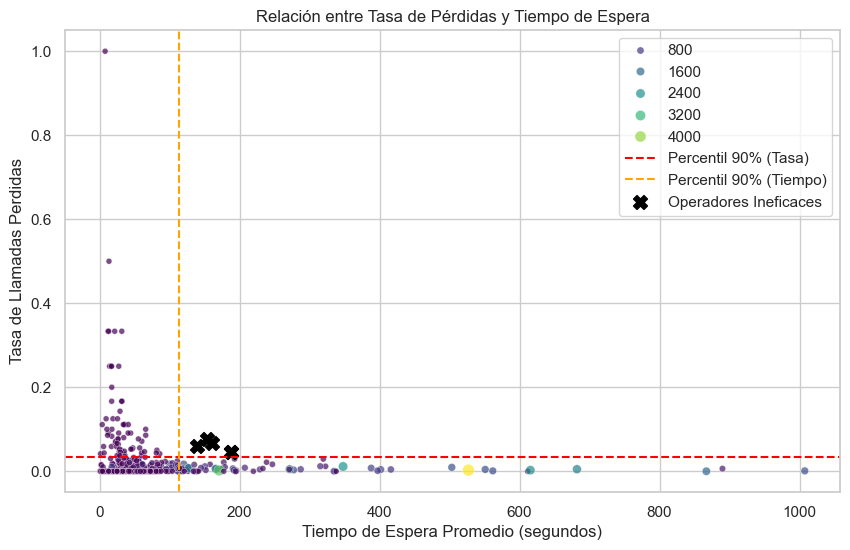

In [23]:


plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=operadores_metrics,
    x="avg_wait_time",
    y="tasa_perdidas",
    hue="total_llamadas_in",
    size="total_llamadas_in",
    palette="viridis",
    alpha=0.7
)
plt.axhline(umbral_tasa, color="red", linestyle="--", label="Percentil 90% (Tasa)")
plt.axvline(umbral_wait, color="orange", linestyle="--", label="Percentil 90% (Tiempo)")

if not operadores_ineficaces.empty:
    plt.scatter(
        operadores_ineficaces["avg_wait_time"],
        operadores_ineficaces["tasa_perdidas"],
        color="black",
        marker="X",
        s=100,
        label="Operadores Ineficaces"
    )

plt.title("Relación entre Tasa de Pérdidas y Tiempo de Espera")
plt.xlabel("Tiempo de Espera Promedio (segundos)")
plt.ylabel("Tasa de Llamadas Perdidas")
plt.legend()
plt.show()


en este diagrama de dispersion podemos visualizar los tiempos promedios de espera de los usuarios  marcamos un limite  y vemos que tenemos 4 usuarios que no cumplen con nuestras metricas establecidas  y otros que rosan con ese limite pero estan dentro de la metrica  


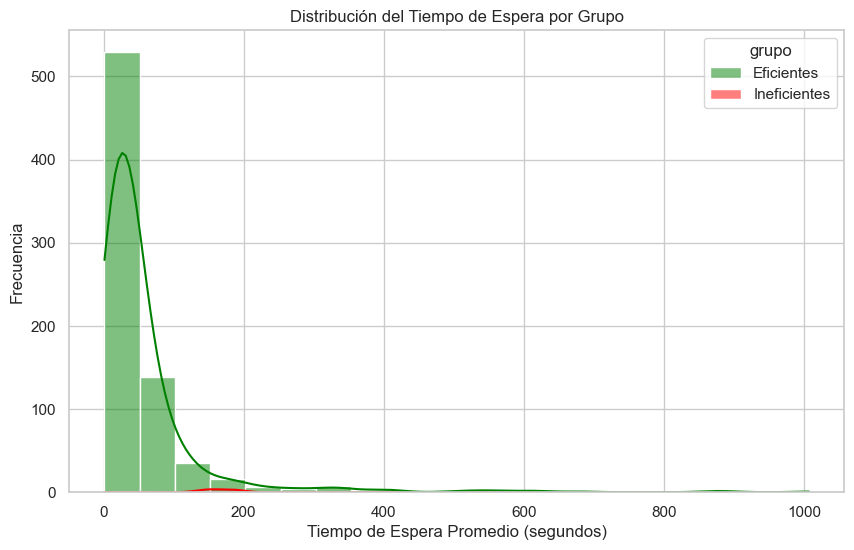

In [24]:
operadores_metrics["grupo"] = np.where(
    operadores_metrics["operator_id"].isin(operadores_ineficaces["operator_id"]),
    "Ineficientes",
    "Eficientes"
)

plt.figure(figsize=(10, 6))

sns.histplot(
    data=operadores_metrics,
    x="avg_wait_time",
    hue="grupo",
    bins=20,
    kde=True,
    palette={"Eficientes": "green", "Ineficientes": "red"}
)

plt.title("Distribución del Tiempo de Espera por Grupo")
plt.xlabel("Tiempo de Espera Promedio (segundos)")
plt.ylabel("Frecuencia")
plt.show()


en la grafica que podemos observar interpretamos el tiempo de espera con usuarios eficicinetes y ineficientes, basandonos en las metricas marcamos en verde los operadores que estan en un buen tiempo de espera  y en rojo los usuarios que su tiempo promedio no es bueno aun que vemos una pequeña linea roja  tenemos otros usuarios que tambien estan al limite del tiempo promedio de espera 

## Hipotesis 1 : Los operadores con llamadas internas tienen menos llamadas perdidas

hipotesis nula: no hay diferencia en la tasa de llamadas perdidas entre operadores  con mas llamadas internas y operadores con menos llamadas internas 

hipotesis alternativa : los operadores con mas llamadas internas tienen  una tasa significativamente  diferente de llamadas perdidas en comparacion con aquellos con menos internas 

In [25]:

op_metrics = df.groupby('operator_id').agg(
    total_calls=('calls_count', 'sum'),
    missed_calls=('is_missed_call', 'sum')
).reset_index()


internal_calls = df[df['internal'] == True].groupby('operator_id').agg(
    internal_calls=('calls_count', 'sum')
).reset_index()

op_metrics = op_metrics.merge(internal_calls, on='operator_id', how='left')
op_metrics['internal_calls'] = op_metrics['internal_calls'].fillna(0)


op_metrics['missed_rate'] = op_metrics.apply(
    lambda row: row['missed_calls'] / row['total_calls'] if row['total_calls'] != 0 else np.nan,
    axis=1
)

median_internal = op_metrics['internal_calls'].median()
group_mas_internas = op_metrics[op_metrics['internal_calls'] > median_internal]
group_menos_internas = op_metrics[op_metrics['internal_calls'] <= median_internal]

t_stat1, p_val1 = ttest_ind(
    group_mas_internas['missed_rate'].dropna(),
    group_menos_internas['missed_rate'].dropna(),
    equal_var=False
)


In [26]:
print("HIPÓTESIS 1: Comparación de la tasa de llamadas perdidas según llamadas internas")
print(f"Estadístico t: {t_stat1:.4f}, Valor p: {p_val1:.4f}")
if p_val1 < 0.05:
    print("Rechazamos la hipótesis nula: existe una diferencia significativa en la tasa de llamadas perdidas.")
else:
    print("No se rechaza la hipótesis nula: no se encuentra diferencia significativa en la tasa de llamadas perdidas.")


HIPÓTESIS 1: Comparación de la tasa de llamadas perdidas según llamadas internas
Estadístico t: -0.0842, Valor p: 0.9329
No se rechaza la hipótesis nula: no se encuentra diferencia significativa en la tasa de llamadas perdidas.


## Hipotesis 2  : El tiempo de espera promedio esta relacionado con la tarifa del cliente 

hipotesis nula : no hay relacion entre el tiempo de espera promedio y  la tarifa del cliente 

hipotesis alternativa : hay una relacion significativa entre el tiempo de  espera promedio y la tarifa del cliente  

In [27]:

df['total_call_duration'] = pd.to_numeric(df['total_call_duration'], errors='coerce')
df['call_duration'] = pd.to_numeric(df['call_duration'], errors='coerce')

df_merged = df.merge(df_clientes, on='user_id')

df_merged['tiempo_espera'] = df_merged['total_call_duration'] - df_merged['call_duration']

df_merged['tariff_plan'] = df_merged['tariff_plan'].astype('category').cat.codes
df_merged['tiempo_espera'] = pd.to_numeric(df_merged['tiempo_espera'], errors='coerce')

espera_por_tarifa = df_merged.groupby('tariff_plan')['tiempo_espera'].mean().reset_index()


In [28]:

corr, p_val = pearsonr(espera_por_tarifa['tariff_plan'], espera_por_tarifa['tiempo_espera'])

print(f'Coeficiente de correlación: {corr:.4f}, Valor p: {p_val:.4f}')
if p_val < 0.05:
    print("Rechazamos la hipótesis nula: hay una relación significativa entre el plan de tarifa y el tiempo de espera.")
else:
    print("No se rechaza la hipótesis nula: no hay evidencia suficiente de una relación significativa.")



Coeficiente de correlación: -0.8459, Valor p: 0.3581
No se rechaza la hipótesis nula: no hay evidencia suficiente de una relación significativa.


## Conclusion 

el análisis exploratorio nos permitió comprender la distribución de las llamadas 
Descubrimos que ciertos operadores acumulaban un número desproporcionado de llamadas entrantes perdidas, lo cual era un indicativo de ineficacia.

observamos que estos operadores también presentaban tiempos de espera significativamente grandes , afectando negativamente la experiencia del cliente.
al considerar las llamadas salientes, identificamos que algunos operadores registraban números bajos.

en la prueba de hipotesis existe una diferencia significativa en la tasa de llamadas perdidas entre operadores con diferentes volúmenes de llamadas internas y entre el plan de tarifa de los clientes y el tiempo de espera promedio, indicando que ciertas tarifas podrían estar asociadas con niveles de servicio diferenciado pero no hay una evidencia solida sobre aquella informacion  

podriamos sugerir entre todos estos casos una formacion un poco mas dedicada hacia los operadores y incentivos para que mantengan unas mejores metricas asi como apoyo mas personalizado a aquellos opreadores que consideramos ineficases.
